# Well Time Series Analysis with Advanced Analytics

This notebook provides comprehensive analysis of well sensor data using advanced outlier detection and visualization techniques.

In [1]:
# Import required libraries
import sys
import os
sys.path.append(os.path.abspath('..'))
print("Current working directory:", os.getcwd())
print("Python executable:", sys.executable)
print("Python path:", sys.path)

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import json
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest 
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from scipy import stats

# Import our custom modules
from src.models.well_ts_model import WellLSTM
from src.utils.data_processor import TagDataProcessor, prepare_dataloader, WellTimeSeriesDataset
from src.utils.outliers import detect_outliers, compare_outlier_methods, detect_time_series_outliers, analyze_seasonal_patterns
from src.utils.visualization_utils import (
    plot_sensor_analysis,
    analyze_data_balance
)
from src.train import train_model

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')  # safer on newer versions

%matplotlib inline
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = [12, 8]

Current working directory: /home/user/deeplearn/notebooks
Python executable: /home/user/deeplearn/venv/bin/python
Python path: ['', '/opt/ros/humble/lib/python3.10/site-packages', '/opt/ros/humble/local/lib/python3.10/dist-packages', '/home/user/isaac-sim/kit/python/lib/python3.10', '/home/user/isaac-sim/kit/python/lib/python3.10/site-packages', '/home/user/isaac-sim/python_packages', '/home/user/isaac-sim/IsaacLab/source', '/home/user/isaac-sim', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '/home/user/deeplearn/venv/lib/python3.10/site-packages', '/home/user/deeplearn']


## 1. Advanced Data Loading and Preprocessing

Enhanced data loading with automatic type inference and timestamp handling.

In [2]:
# Load and preprocess data
data_path = '../data/tagdata.csv'
config_path = '../data/tag_config.json'

processor = TagDataProcessor(config_path)
data = processor.load_and_preprocess_data(data_path)

# Display basic statistics
print("Dataset Overview:")
print(f"Total samples: {len(data)}")
print(f"Features: {data.columns.tolist()}")
print("\nBasic Statistics:")
display(data.describe())

# Check data types and missing values
print("\nData Types:")
display(data.dtypes)
print("\nMissing Values:")
display(data.isnull().sum())


=== Data Loading Debug Information ===
Loading data from: ../data/tagdata.csv

Raw CSV file information:
Shape: (819674, 7)
Columns: ['Id', 'TagAlias', 'Timestamp', 'byteValue', 'DisplayValue', 'Quality', 'WellDeviceID']

First few rows of raw data:
   Id      TagAlias                    Timestamp    byteValue  DisplayValue  \
0   4  Area1Visible  2025-02-24 12:26:42.0929314  b'\x01\x00'             1   
1   7  Area2Visible  2025-02-24 12:26:42.0929314  b'\x01\x00'             1   
2  10  Area3Visible  2025-02-24 12:26:42.0929314  b'\x01\x00'             1   
3  13  Area4Visible  2025-02-24 12:26:42.0929314  b'\x01\x00'             1   
4  16  Area5Visible  2025-02-24 12:26:42.0929314  b'\x01\x00'             1   

   Quality                          WellDeviceID  
0  HEALTHY  DB12CFA3-340D-4A46-B9C7-000648BFEE9F  
1  HEALTHY  DB12CFA3-340D-4A46-B9C7-000648BFEE9F  
2  HEALTHY  DB12CFA3-340D-4A46-B9C7-000648BFEE9F  
3  HEALTHY  DB12CFA3-340D-4A46-B9C7-000648BFEE9F  
4  HEALTHY  DB12CFA

TagAlias,ICV5FlowStep9Min,ICV6FlowStep8Max,VMM3TubingTVisible,VMM5TubingPAlarm,VMM5AnnulusTVisible,ICV6FlowStep9Max,ICV5FlowStep6Max,ICV4FlowStep8Max,VMM2AnnulusTAlarm,ICV3FlowStep2Min,...,ICV5FlowStep7Max,ICV1FlowStep20Min,ICV4FlowStep2Max,ICV6FlowStep6Max,VMM2VibrationZVisible,ICV3FlowStep1Max,VMM1TubingTVisible,VMM3VibrationYVisible,ICV1FlowStep16Max,VMM6TubingPVisible
count,2673.0,2673.0,2673.0,2673.0,2673.0,2673.0,2673.0,2673.0,2673.0,2673.0,...,2673.0,2673.0,2673.0,2673.0,2673.0,2673.0,2673.0,2673.0,2673.0,2673.0
mean,81.0,80.0,1.0,3.0,1.0,90.0,60.0,80.0,3.0,11.0,...,70.0,95.0,20.0,60.0,1.0,10.0,1.0,1.0,80.0,1.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,81.0,80.0,1.0,3.0,1.0,90.0,60.0,80.0,3.0,11.0,...,70.0,95.0,20.0,60.0,1.0,10.0,1.0,1.0,80.0,1.0
25%,81.0,80.0,1.0,3.0,1.0,90.0,60.0,80.0,3.0,11.0,...,70.0,95.0,20.0,60.0,1.0,10.0,1.0,1.0,80.0,1.0
50%,81.0,80.0,1.0,3.0,1.0,90.0,60.0,80.0,3.0,11.0,...,70.0,95.0,20.0,60.0,1.0,10.0,1.0,1.0,80.0,1.0
75%,81.0,80.0,1.0,3.0,1.0,90.0,60.0,80.0,3.0,11.0,...,70.0,95.0,20.0,60.0,1.0,10.0,1.0,1.0,80.0,1.0
max,81.0,80.0,1.0,3.0,1.0,90.0,60.0,80.0,3.0,11.0,...,70.0,95.0,20.0,60.0,1.0,10.0,1.0,1.0,80.0,1.0



Data Types:


TagAlias
ICV5FlowStep9Min         float64
ICV6FlowStep8Max         float64
VMM3TubingTVisible       float64
VMM5TubingPAlarm         float64
VMM5AnnulusTVisible      float64
                          ...   
ICV3FlowStep1Max         float64
VMM1TubingTVisible       float64
VMM3VibrationYVisible    float64
ICV1FlowStep16Max        float64
VMM6TubingPVisible       float64
Length: 226, dtype: object


Missing Values:


TagAlias
ICV5FlowStep9Min         0
ICV6FlowStep8Max         0
VMM3TubingTVisible       0
VMM5TubingPAlarm         0
VMM5AnnulusTVisible      0
                        ..
ICV3FlowStep1Max         0
VMM1TubingTVisible       0
VMM3VibrationYVisible    0
ICV1FlowStep16Max        0
VMM6TubingPVisible       0
Length: 226, dtype: int64

## 2. Advanced Outlier Detection

Multiple methods for robust outlier detection in sensor data.

/home/user/deeplearn/src/utils/outliers.py:40: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = np.abs(stats.zscore(data[columns]))


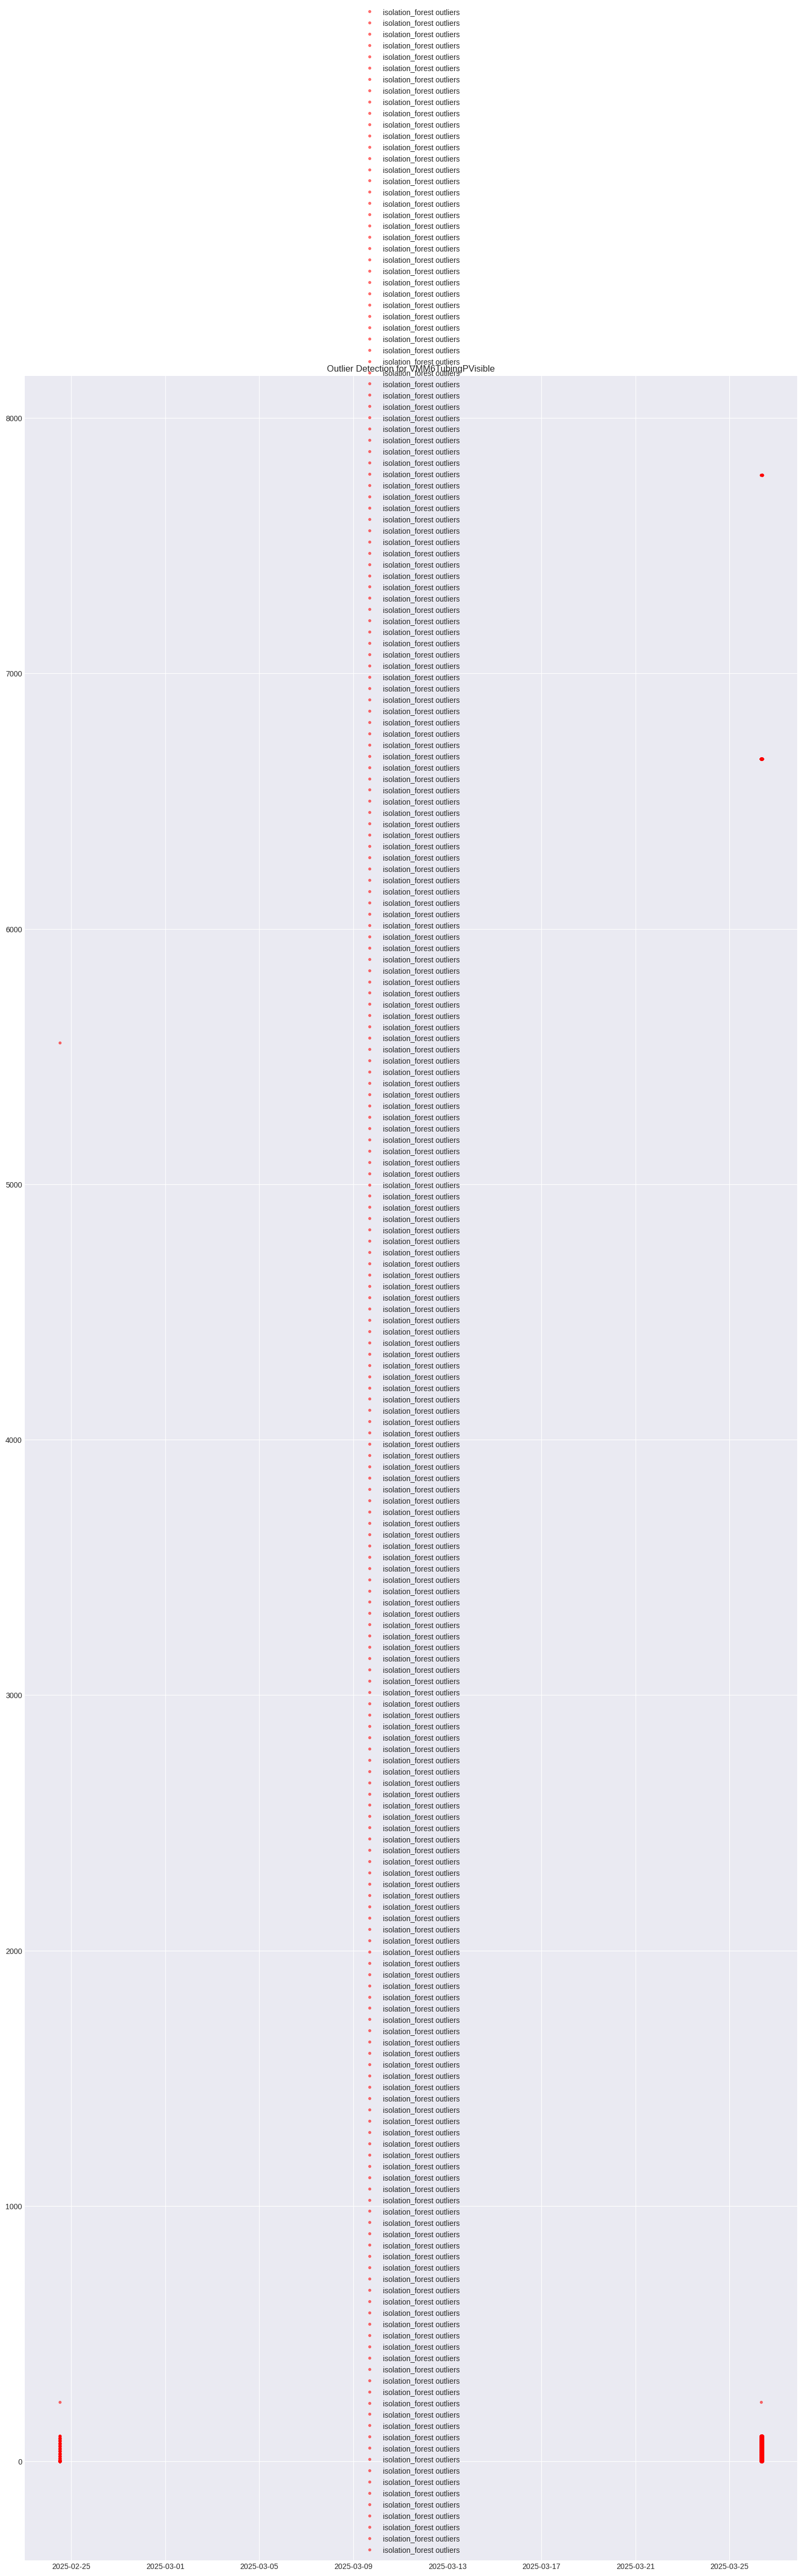

In [6]:
# Detect outliers for numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
outliers = detect_outliers(data, numeric_columns)
max_columns = 10  # Maximum number of columns to consider for figure size
num_columns = min(len(numeric_columns), max_columns)
plt.figure(figsize=(15, 5 * num_columns))

for col in numeric_columns:
    # Your plotting code here
    for method, indices in outliers.items():
        indices = np.array(indices, dtype=int)
        valid_indices = indices[(indices >= 0) & (indices < len(data))]
        if valid_indices.size > 0:
            plt.plot(data.index[valid_indices], data[col].iloc[valid_indices],
                     'r.', label=f'{method} outliers', alpha=0.5)
    plt.title(f'Outlier Detection for {col}')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

# For each numeric column in your data
for column in data.select_dtypes(include=[np.number]).columns:
    compare_outlier_methods(data, column)

## 3. Time Series Outlier Detection 
Rolling Z-Score & Seasonal Decomposition
.

In [ ]:
# Example usage
for tag in data['tagalias'].unique():
    print(f"\nAnalyzing tag: {tag}")
    outliers = detect_time_series_outliers(data, tag)
    analyze_seasonal_patterns(data, tag)

## 4. Enhanced Data Visualization

In [ ]:

# Plot analysis for each tag alias
for tag in data['tagalias'].unique():
    plot_sensor_analysis(data, tag)

## 5. Data Balance Analysis

In [ ]:

# Analyze data balance
analyze_data_balance(data)

## 6. Advanced Feature Engineering

In [ ]:
def engineer_features(data):
    """Create advanced features for time series analysis"""
    # Convert timestamp to datetime if not already
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    
    # Time-based features
    data['hour'] = data['timestamp'].dt.hour
    data['day_of_week'] = data['timestamp'].dt.dayofweek
    data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
    
    # Rolling statistics
    windows = [5, 10, 20]
    for window in windows:
        data[f'rolling_mean_{window}'] = data.groupby('tagalias')['value'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        data[f'rolling_std_{window}'] = data.groupby('tagalias')['value'].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )
    
    # Lag features
    lags = [1, 2, 3, 5, 10]
    for lag in lags:
        data[f'lag_{lag}'] = data.groupby('tagalias')['value'].shift(lag)
    
    # Difference features
    data['diff_1'] = data.groupby('tagalias')['value'].diff()
    data['diff_2'] = data.groupby('tagalias')['value'].diff(2)
    
    # Percentage change
    data['pct_change'] = data.groupby('tagalias')['value'].pct_change()
    
    # Fill NaN values created by transformations
    data = data.fillna(method='bfill').fillna(method='ffill')
    
    return data

# Engineer features
data_engineered = engineer_features(data.copy())

# Display correlation heatmap of engineered features
plt.figure(figsize=(15, 12))
sns.heatmap(data_engineered.select_dtypes(include=[np.number]).corr(),
            annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

## 7. LSTM Model Architecture and Training

Implementation of an LSTM model with attention mechanism for time series prediction.

In [ ]:
class AttentionLSTM(nn.Module):
    """LSTM model with attention mechanism for time series prediction"""
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(AttentionLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1)
        )
        
        # Output layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x, hidden=None):
        batch_size = x.size(0)
        
        # Initialize hidden state if not provided
        if hidden is None:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
            hidden = (h0, c0)
        
        # LSTM forward pass
        lstm_out, hidden = self.lstm(x, hidden)
        
        # Attention mechanism
        attention_weights = self.attention(lstm_out)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        
        # Output layer
        out = self.fc(context_vector)
        
        return out, attention_weights

In [ ]:
def prepare_training_data(data_engineered, sequence_length=24, prediction_horizon=1, train_ratio=0.8):
    """Prepare data for training"""
    # Select features for training
    feature_columns = [
        'value', 'hour', 'day_of_week', 'is_weekend',
        'rolling_mean_5', 'rolling_std_5',
        'lag_1', 'lag_2', 'diff_1', 'pct_change'
    ]
    
    # Scale features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_engineered[feature_columns])
    scaled_df = pd.DataFrame(scaled_data, columns=feature_columns)
    
    # Create sequences
    X, y = [], []
    for i in range(len(scaled_df) - sequence_length - prediction_horizon + 1):
        X.append(scaled_df.iloc[i:i+sequence_length].values)
        y.append(scaled_df.iloc[i+sequence_length+prediction_horizon-1]['value'])
    
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    
    # Split into train and validation sets
    train_size = int(len(X) * train_ratio)
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]
    
    # Create data loaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    return train_loader, val_loader, scaler

# Prepare data for training
train_loader, val_loader, scaler = prepare_training_data(data_engineered)

# Model parameters
input_size = 10  # Number of input features
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 50

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AttentionLSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """Train the model"""
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            output, _ = model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                output, _ = model(X_batch)
                loss = criterion(output.squeeze(), y_batch)
                val_loss += loss.item()
        
        # Calculate average losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'scaler': scaler
            }, 'best_model.pth')
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}')
    
    return train_losses, val_losses

# Train the model
train_losses, val_losses = train_model(
    model, train_loader, val_loader,
    criterion, optimizer, num_epochs, device
)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 8. Model Evaluation and Prediction Visualization

In [ ]:
def evaluate_predictions(model, val_loader, scaler, device):
    """Evaluate model predictions"""
    model.eval()
    predictions = []
    actuals = []
    attention_weights_list = []
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            
            output, attention_weights = model(X_batch)
            
            predictions.extend(output.cpu().numpy())
            actuals.extend(y_batch.numpy())
            attention_weights_list.extend(attention_weights.cpu().numpy())
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    attention_weights_list = np.array(attention_weights_list)
    
    # Inverse transform predictions and actuals
    predictions_orig = scaler.inverse_transform(predictions)
    actuals_orig = scaler.inverse_transform(actuals)
    
    # Calculate metrics
    mse = mean_squared_error(actuals_orig, predictions_orig)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals_orig, predictions_orig)
    r2 = r2_score(actuals_orig, predictions_orig)
    
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'R² Score: {r2:.4f}')
    
    # Plot predictions vs actuals
    plt.figure(figsize=(15, 6))
    plt.plot(actuals_orig, label='Actual')
    plt.plot(predictions_orig, label='Predicted')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    
    # Plot attention weights heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(attention_weights_list[0], cmap='viridis')
    plt.title('Attention Weights Heatmap')
    plt.xlabel('Time Steps')
    plt.ylabel('Features')
    plt.show()

# Evaluate the model
evaluate_predictions(model, val_loader, scaler, device)

## 9. Advanced Training Utilities

Additional utilities for improved model training and validation.

In [ ]:
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=7, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            
def train_model_advanced(model, train_loader, val_loader, criterion, optimizer, 
                        num_epochs, device, patience=7, scheduler_factor=0.1):
    """Advanced training with early stopping and learning rate scheduling"""
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=scheduler_factor, patience=patience//2, verbose=True
    )
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            output, _ = model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_predictions = []
        val_actuals = []
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                output, _ = model(X_batch)
                loss = criterion(output.squeeze(), y_batch)
                val_loss += loss.item()
                
                val_predictions.extend(output.cpu().numpy())
                val_actuals.extend(y_batch.cpu().numpy())
        
        # Calculate average losses and metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Calculate validation metrics
        val_predictions = np.array(val_predictions)
        val_actuals = np.array(val_actuals)
        val_mse = mean_squared_error(val_actuals, val_predictions)
        val_rmse = np.sqrt(val_mse)
        val_mae = mean_absolute_error(val_actuals, val_predictions)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'val_metrics': {
                    'mse': val_mse,
                    'rmse': val_rmse,
                    'mae': val_mae
                },
                'scaler': scaler
            }, 'best_model.pth')
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        print(f'Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}')
        
        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    
    return train_losses, val_losses

# Train with advanced features
train_losses, val_losses = train_model_advanced(
    model, train_loader, val_loader,
    criterion, optimizer, num_epochs, device
)

# Plot training history with moving averages
def plot_training_history(train_losses, val_losses, window=5):
    plt.figure(figsize=(12, 6))
    
    # Calculate moving averages
    train_ma = pd.Series(train_losses).rolling(window=window).mean()
    val_ma = pd.Series(val_losses).rolling(window=window).mean()
    
    plt.plot(train_losses, label='Training Loss', alpha=0.3)
    plt.plot(val_losses, label='Validation Loss', alpha=0.3)
    plt.plot(train_ma, label=f'Training Loss ({window}-epoch MA)', linewidth=2)
    plt.plot(val_ma, label=f'Validation Loss ({window}-epoch MA)', linewidth=2)
    
    plt.title('Model Training History with Moving Averages')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(train_losses, val_losses)

In [ ]:
def k_fold_cross_validation(data_engineered, k=5, sequence_length=24, prediction_horizon=1):
    """Perform k-fold cross-validation"""
    # Prepare data
    feature_columns = [
        'value', 'hour', 'day_of_week', 'is_weekend',
        'rolling_mean_5', 'rolling_std_5',
        'lag_1', 'lag_2', 'diff_1', 'pct_change'
    ]
    
    # Scale features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_engineered[feature_columns])
    scaled_df = pd.DataFrame(scaled_data, columns=feature_columns)
    
    # Create sequences
    X, y = [], []
    for i in range(len(scaled_df) - sequence_length - prediction_horizon + 1):
        X.append(scaled_df.iloc[i:i+sequence_length].values)
        y.append(scaled_df.iloc[i+sequence_length+prediction_horizon-1]['value'])
    
    X = torch.FloatTensor(np.array(X))
    y = torch.FloatTensor(np.array(y))
    
    # Prepare k-fold cross-validation
    fold_size = len(X) // k
    metrics = []
    
    for fold in range(k):
        print(f'\nFold {fold+1}/{k}')
        
        # Split data
        val_start = fold * fold_size
        val_end = (fold + 1) * fold_size
        
        X_train = torch.cat([X[:val_start], X[val_end:]])
        y_train = torch.cat([y[:val_start], y[val_end:]])
        X_val = X[val_start:val_end]
        y_val = y[val_start:val_end]
        
        # Create data loaders
        train_dataset = TensorDataset(X_train, y_train)
        val_dataset = TensorDataset(X_val, y_val)
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        
        # Initialize model
        model = AttentionLSTM(input_size, hidden_size, num_layers, output_size).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        # Train model
        train_losses, val_losses = train_model_advanced(
            model, train_loader, val_loader,
            criterion, optimizer, num_epochs, device
        )
        
        # Evaluate fold
        model.eval()
        val_predictions = []
        with torch.no_grad():
            for X_batch, _ in val_loader:
                X_batch = X_batch.to(device)
                output, _ = model(X_batch)
                val_predictions.extend(output.cpu().numpy())
        
        val_predictions = np.array(val_predictions)
        val_actuals = y_val.numpy()
        
        # Calculate metrics
        fold_metrics = {
            'mse': mean_squared_error(val_actuals, val_predictions),
            'rmse': np.sqrt(mean_squared_error(val_actuals, val_predictions)),
            'mae': mean_absolute_error(val_actuals, val_predictions),
            'r2': r2_score(val_actuals, val_predictions)
        }
        
        metrics.append(fold_metrics)
        print(f'Fold {fold+1} Metrics:')
        for metric, value in fold_metrics.items():
            print(f'{metric.upper()}: {value:.4f}')
    
    # Calculate and print average metrics
    print('\nAverage Metrics across all folds:')
    avg_metrics = {}
    for metric in metrics[0].keys():
        avg_metrics[metric] = np.mean([fold[metric] for fold in metrics])
        print(f'{metric.upper()}: {avg_metrics[metric]:.4f}')
    
    return metrics, avg_metrics

# Perform k-fold cross-validation
fold_metrics, avg_metrics = k_fold_cross_validation(data_engineered)